# NTDS: A dive into the musical industry

The goal of this project is to look into the relationships between the different members of the music industry. This means we will not look into only the well known interprets that you can hear on the radio everyday, but also into the people in the shadows that help them with their lyrics and the production of their songs. 

We hope that this project will help us understand if the music industry is a very much connected network or not, if the people working with one another are always coming from the same genre or not, if friendship between artists can be found through their songs metadata (who wrote it, who produced it, etc...) and finally if the label haves that much of an influence than we could think before hand on the working relationships.

Before jumping right into the notebook, we will quickly talk about the different tools we used to do our study:
1. the **pandas** library to work with dataframe
2. the **numpy** library
3. the **re** library to be able to clean the data using regular expressions
4. the **netwrokx** library to be able to visualize the graphs and create easy to use graph from adjacency matrix
5. the **random** library
6. the **seaborn** library to be have colorful plots
7. the **collection** library
8. the **matplotlib** library to recover plotting tools from matlab
9. the **sklearn** library to use already implemented clustering algorithms
10. the **community** library allowing the use of a python implementation of the Louvain method for community detection
11. the **bokeh** library to create interactive plots

NOTE: Reruning the notebook will probably changes some of the results of te clustering algorithms. For example the Louvain method solves an optimization problem and will not always output the exactly identical partionning. Thus our analysis might changes a little (a community is not divised in two distinct anymore for example).

In [27]:
import pandas as pd
import numpy as np
import re
import networkx as nx
import random
import seaborn as sns
import collections
from collections import Counter
import operator
import matplotlib.pyplot as plt

from sklearn.cluster import SpectralClustering, DBSCAN
import community

from bokeh.io import show, output_notebook
from bokeh.models import Plot, Range1d, MultiLine, Circle, HoverTool, BoxZoomTool, ResetTool, WheelZoomTool, PanTool
from bokeh.models.graphs import from_networkx
from bokeh.palettes import Spectral4, Inferno256, Spectral, Viridis256, Cividis256

output_notebook()

Loading BokehJS ...

The data we used is a combination of a spotify dataset created on Kaggle by Zaheen Hamidani (https://www.kaggle.com/zaheenhamidani/ultimate-spotify-tracks-db) and of the Genius API's informations we are able to pull. The data spans the music industry from the 1950s to the year 2018 and encapsulates the majority of popular genres. The data from Kaggle contained 148615 unique songs at first, but since we did pulled request on Genius taking arround 0.5 seconds per song, our final dataset contained a total of 70681 unique songs. 

This notebook is structured in the following way:
we first are going to do some data preparation to be able to work on the cleanest as possible data. Note that the data is obtained in the notebook called **NTDS_project** by using an already pulled data from spotify and by pulling data from the Genius API for the songs we obtained from spotify. We then will run a study of the data to clearly know who are the persons present in the dataset and what informations we can obtained for them. Once this analysis done, we are going to define our adjacency matrix. Once created, we will this time create the corresponding graph. Then, we will apply some clustering algorithms to see if we are able to discover any interessting things from the graph structure of our data. Finally we are going to lead more precise studies on small part of the data based on different criterias.

## Data preparation

The first thing we have to do before anything is to clean the dataframe. We will achieve it by splitting/parsing the *more_infos* columns from the original data we pulled in the best way possible. In the end we want to obtain the following informations about each songs:

    1. names of all the songwritters
    2. names of all the producers
    3. names of the labels who put it in the charts

Note that the majority of songs we obtained are so that no informations are recoverable. in the case only the artist (interpret) name is available, we decided that he both wrote and produced his song alone. Also, if no information about labels is recovered for song, the song is considered has independently created (denoted as *independent* in our work).

In the following cell, we load the dataframe we have created from the Kaggle dataset on Spotify songs and with the respective Genius informations. If you have not access to this dataframe, you'll have to run the other notebook present on this Git to pull data (see explanation there).

In [2]:
# if already created
artists_writers_df = pd.read_pickle("artists_writers_df.pkl")
artists_writers_df = artists_writers_df.drop_duplicates(['track_name', 'artist'])

The dataframe we created has at first the following format:
1. **indx**
2. **track_name**: the name of the song
3. **artist**: the interpret of the song
4. **genre**: the genre of the song. It can be one of the following: 'Alternative', 'Blues', 'Country', 'Dance', 'Electronic', 'Folk', 'Hip-Hop', 'Indie', 'Pop', 'R&B', 'Rap', 'Reggae', 'Reggaeton'
5. **popularity**: representation of the relevance of a song (listens wise) on Spotify at the time of pulling the data from 0 to 100
6. **more_infos**: columns containing all the HTML data obtained from the html requests on Genius

In [3]:
artists_writers_df.head(10)

track_name          artist genre popularity  \
0             Be Without You   Mary J. Blige   R&B         65   
1                  Desperado         Rihanna   R&B         63   
2            Ice On My Baby        Yung Bleu   R&B         62   
3  Heaven Falls / Fall on Me        Surfaces   R&B         61   
4                Love Myself  Olivia O'Brien   R&B         68   
5                      Needs           ELHAE   R&B         61   
6         Make It Out Alive              Nao   R&B         64   
7                  Seigfried     Frank Ocean   R&B         66   
8              Roll In Peace   Layton Greene   R&B         60   
9       You Make Me Wanna...           Usher   R&B         69   

                                          more_infos  
0  [Strings,artists:[{_type:artist,api_path:/arti...  
1  [Distributor,artists:[{_type:artist,api_path:/...  
2  [Video,overlay_compatible_image_url:https://im...  
3                                                 []  
4  [Video,overlay_compatible_image_url:https://im...  
5                                                 []  
6  [Mastering Engineer,artists:[{_type:artist,api...  
7  [news,overlay_compatible_image_url:https://ima...  
8  [feature,overlay_compatible_image_url:https://...  
9  [news,overlay_compatible_image_url:https://ima...

Now that the dataframe is loaded, we can start working and the creation of the new one. To do this we defined the following functions: **create_final_dataframe(df)** and ** **format_string(string)** \

- **create_final_dataframe(df)**: Function that allows the parsing of the infos we obtained about our songs. Note that the parsing was facilated from the fact that some indicators where already present in the text obtained after a request for the more popular songs. But, on the other hand, data about less well known songs was badly represented and thus we could have losts informations about these songs. Case by case we tried to solve the majority of the problem (using for example the format_string function) but some mistakes of parsing might still be present in the dataframe.

- **format_string(string)**: Given a string, normalize its format using regex expression. (note we filled this function step by step as errors where seen in latter studies)

Finally note that when you go on Genius, some songs that have no producers related information in the html request have some informations about it on the top of the website's page. We are faced in this case by a dilemma; either we decide to drop this songs, or as said above, we assume the artist worked on his own on the song. We chose the second options, which may leads to analysis errors later on but allow us to have a wider range of data to work on.

In the cell below, you can find the definition of the two function we presented above.

In [4]:
def format_string(string):
    
    '''
    Given a string, normalize its format using regex expression. (note we filled this function step by step as errors where
    seen in latter on studies)
    INPUT: string: string to be modified
    OUTPUT: string: string modified
    '''
    
    string = re.sub("’", "'", string)
    string = re.sub("é", "e", string)
    string = re.sub(r'[^\x00-\x7F]+',' ', string)
    string = re.sub('amp;', '', string)
    string = re.sub('-', ' ', string)
    while string[0] == ' ' and len(string) > 1:
        string = string[1:]
    
    string = string.lower()
    
    return string

def create_final_dataframe(df):
    
    '''
    Function that allows the parsing of the infos we obtained about our songs
    INPUT: dataframe containing the joint informations from the Spotify dataset of songs and teh Genius API requests
    OUPUT: new, well formated dataframe
    '''
    
    columns_list = ['track_name','artist_name','songwriters','producers','labels','genre','popularity']
    new_df = pd.DataFrame(columns=columns_list)
    
    
    for row in df.iterrows():
        artist_name = format_string(row[1]['artist'])
        track_name = row[1]['track_name']
        popularity = row[1]['popularity']
        genre = row[1]['genre']
        writters = []
        labels = []
        producers = []
        
        if len(row[1]['more_infos']) != 0:
            for el in row[1]['more_infos']:
                # writers of the songs
                if 'writer_artists' in str(el):
                    for name in str(str(el).split('writer_artists')[1]).split('name:')[1:]:
                        writters.append(format_string(str(name).split(',')[0]))
                # we use this second condition to be sure to miss no writters in specific cases
                if 'artists' in str(el) and 'news' not in str(el): 
                    if(str(el).split(':')[0] == 'Lyricist,artists'):
                        for name in str(el).split('name:')[1:]:
                            writters.append(format_string(str(name).split(',')[0]))
                # We assume that if no writters ar mentionned that the artist wrote the song
                if len(writters) == 0:
                    writters = [artist_name]

                # labels of the songs
                if 'Label,artists' in str(el):
                    for name in str(str(el).split('Label,artists')[1]).split('}]')[0].split('name:')[1:]:
                        labels.append(format_string(str(name).split(',')[0]))

                # producers of the song
                if 'producer_artists' in str(el):
                    for name in str(str(el).split('producer_artists')[1]).split('}]')[0].split('name:')[1:]:
                        producers.append(format_string(str(name).split(',')[0]))
                
            
            # we assume that if no label is mentionned that the artist is independent
            if len(labels) == 0:
                labels = ['independent']
                
            # we assume that if no producer is mentionned that the artist produced the song himself
            if len(producers) == 0:
                    producers = [artist_name]

            writters = np.unique(writters)
            producers = np.unique(producers)
            new_row = pd.DataFrame([[track_name, artist_name, writters, producers, \
                                     labels, genre, popularity]], columns=columns_list)
            new_df = new_df.append(new_row, ignore_index=True)
        
    return new_df

In the following cell, we apply our function to create the final dataframe and give a sneak peak at what our data now looks like.

In [5]:
final_dataframe = create_final_dataframe(artists_writers_df)
final_dataframe.head(2)

track_name    artist_name  \
0  Be Without You  mary j. blige   
1       Desperado        rihanna   

                                         songwriters  \
0  [bryan michael cox, jason perry, johnt  austin...   
1  [banks, d. rachel, james fauntleroy, mick schu...   

                                       producers                       labels  \
0                            [bryan michael cox]             [geffen records]   
1  [james fauntleroy, kuk harrell, mick schultz]  [westbury road, roc nation]   

  genre popularity  
0   R&B         65  
1   R&B         63

## General study of the data.

In this part we are going to do some studies on our dataset. These studies consist mainly into showing how our dataframe is populated. We are going to first look into the songwriters column contained in our dataframe, then the labels one and finally into the producers one. The functions we will present to you latter on allows us to look into who are the most present persons in our dataset (more prolific), what are the most succesfull songs someone worked on, what are the artist with whom someone worked, etc...

The first function you can looked into below, **plot_n_most_common_persons(count_data, n, x_lab='None', y_lab='None', title= 'None')** allows us to plot into a bar plot graph which are the person who worked on the most songs for a given count_data. The count_data corresponds to a role specific columns in our dataframe. For example we work on only the producers of our dataset and output the most prolific producers.

In [6]:
# Helper function
def plot_n_most_common_persons(count_data, n, x_lab='None', y_lab='None', title= 'None'):
    
    '''
    plot the n person that wrote/produced/interpret the most songs in the dataset count_data.
    INPUT: count_data: dictionnary containing the name of music industry person and the number of songs he helped create
           n: number of persons we want to be plotted
           x_lab: label of the xaxis
           y_lab: label of the yaxis
    
    '''
    
    count_dict = sorted(count_data.items(), key=operator.itemgetter(1), reverse=True)[:n]
    names = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(names)) 
    if n == -1:
        n = '(all)'
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title= 'top ' + str(n) + ': ' + title)
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, names, rotation=90) 
    plt.xlabel(x_lab)
    plt.ylabel(y_lab)
    plt.show()

### A quick study of the songwriters

The first study we are going to lead is an analysis of the most prolific songwriters in our dataset. To do so we are going to use the function described above for plotting and we will create a list containing all the songwriters present in our dataframe (with duplicates, allowing us to know the most prolific ones buy counting).

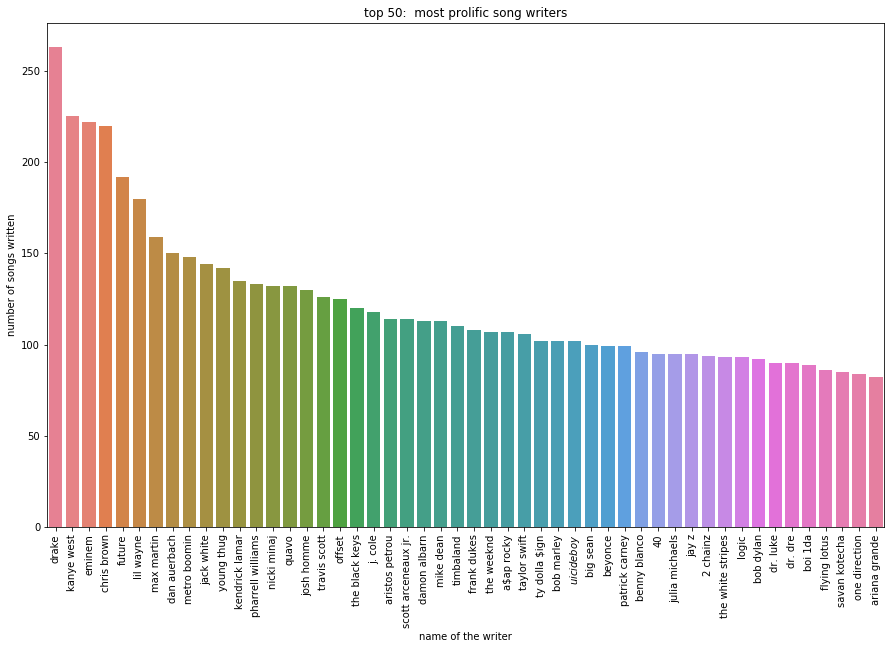

In [7]:
# creation of the list of all the songwriters in our dataframe
songwriters_list = []
for list_ in final_dataframe['songwriters'].values:
    for elem in list_:
        songwriters_list.append(elem)

# now lets count the number of occurences of each songwriter in our dataset
song_writers_dictionnary = dict(collections.Counter(songwriters_list))

# lets plot our data (50 most common)
plot_n_most_common_persons(song_writers_dictionnary, 50, x_lab='name of the writer', y_lab='number of songs written', title=' most prolific song writers')

First thing we can recover from this plot is that lots of the artist are in fact also songwriters. But this information should be taken with a grain of salt, indeed it seems like lots of interpret are always credited as songwriter in their song even though they are not. For example, the biggest songwriter in our dataframe is Drake who faced lots of contreversy on the subject of ghostwriters. This study can tell us that the data obtained from the music industry could be not completly honest with the customers and that the person that are presented as songwriters might not always be ones and that some people might have been left out by choice.

On a positive aspect, you an see in the top 10 the name of Max Martin which is not a known performer. When going to Wikipedia, we can find that he is one of the most recognize dsongwriter in the music industry. He worked for lots of popular artist like Arianna Grande and the Backstreet Boys.\
This information tell us that our data grasp informations about people behind the songs in addition to the interprets.  The study we thus want to lead is possible with the dataset we obtained.

One thing we want to be able to do in this notebook is to avoid needing to go to Wikepedia or any other website to obtain informations about persons we dont know. We thus decided to implement multiple functions allowing us to study a specific actor in our dataframe (role based approach). These functions are the following:

- **find_songs_for_given_person(df, column_of_interest, name)**: find all the songs a specific person worked on with a specific role. For example we can study the role of Drake only as a producer or only as a songwriter.
- **find_main_genre_for_given_person(df, name)**: return the main genre on which a specific person worked on (role independent).
- **print_artist_worked_with(list_of_songs, name, plot_artist_himself=True, n=50)**: print the name of interprets with whom the selected person worked the most.
- **print_more_popular_track(list_of_songs, name, n)**: print the most ppular tracks an person worked on.
- **study_actor(df, name, role, n=40,  plot_artist_himself=True)**: function using all the one described above and allowing us to study an actor of the industry in depth for a specific role. We can easily use it to study the actor in each of the different roles he can fill (interpret/songwriter/producer).

These functions are all implemented in the cell below.

In [8]:
def find_songs_for_given_person(df, column_of_interest, name):
    
    '''
    find the songs that a given person helped created
    INPUT: df: dataframe of our cleaned data.
           column_of_interest: the role of the person we are looking for (producer or song_writer)
           name: name of the person we want to obtain informations about
    OUTPUT: list_of_songs: all the songs on which the person worked
    '''
    
    list_of_songs = []
    for row in df.iterrows():
        if name in row[1][column_of_interest]:
            to_append = (row[1]['track_name'], row[1]['artist_name'], row[1]['popularity'])
            list_of_songs.append(to_append)
    return list_of_songs

def find_main_genre_for_given_person(df, name):
    
    '''
    Return the the main genre on which a person worked
    INPUT: df: dataframe of our cleaned data.
           name: name of the person we want to obtain informations about.
    OUTPUT: the genre in which the artist is the most prolific
    '''
    
    genres = {}
    for row in df.iterrows():
        if (name in row[1]['artist_name'] or name in row[1]['songwriters']  or name in row[1]['producers']):
            genre = row[1]['genre']
            if genre not in genres.keys():
                genres[genre] = 1
            else:
                genres[genre] +=1
    return max(genres.items(), key=operator.itemgetter(1))[0]



def print_artist_worked_with(list_of_songs, name, plot_artist_himself=True, n=50):
    
    '''
    plot all the artist which the person of interest worked with
    INPUT: list_of_songs: The songs on which the producer/writer worked on
           name: the name of the producer/writer/label
    '''
    
    dict_artists = {}
    for tup in list_of_songs:
        name_ = tup[1]
        if name_ in dict_artists.keys():
            dict_artists[name_] +=1
        else:
            dict_artists[name_] = 1
    
    if not(plot_artist_himself):        
        del dict_artists[name]
    
    if len(dict_artists) < n:
        n = -1
    plot_n_most_common_persons(dict_artists, n, x_lab= 'artists who worked with ' + name, \
                               y_lab='number of songs done together', title= 'number of songs done by artists with ' + name)
    
def print_more_popular_track(list_of_songs, name, n):
    
    '''
    Plot the most popular track (at the time of the pull) that the producer/writer worked on
    INPUT: list_of_songs: The songs on which the producer/writer worked on
           name: the name of the producer/writer/label
           n: the n most popular track you want to plot
    '''
    
    dict_popularity = {}
    for tup in list_of_songs:
        name_ = tup[1]
        track = tup[0]
        dict_popularity[track + ' by ' + name_] = tup[2]
        
    plot_n_most_common_persons(dict_popularity, n, x_lab= 'songs on which ' + name + ' worked', \
                               y_lab='popularity of the songs', title= 'more popular tracks from ' + name)
    
def study_actor(df, name, role, n=40,  plot_artist_himself=True):
    
    '''
    Full study of the work of a person place in the industry
    INPUT: df: dataframe of our cleaned data.
           column_of_interest: the role of the person we are looking for (producer or song_writer or even label)
           name: name of the person/label we want to obtain informations about
    
    '''
    
    list_of_songs = find_songs_for_given_person(df, role, name)
    print_artist_worked_with(list_of_songs, name, plot_artist_himself=plot_artist_himself, n=n)
    print_more_popular_track(list_of_songs, name, n)

We talked previously about the songwriter Max Martin using his Wikipedia page. But could we have obtained the information we presented using only our dataframe?

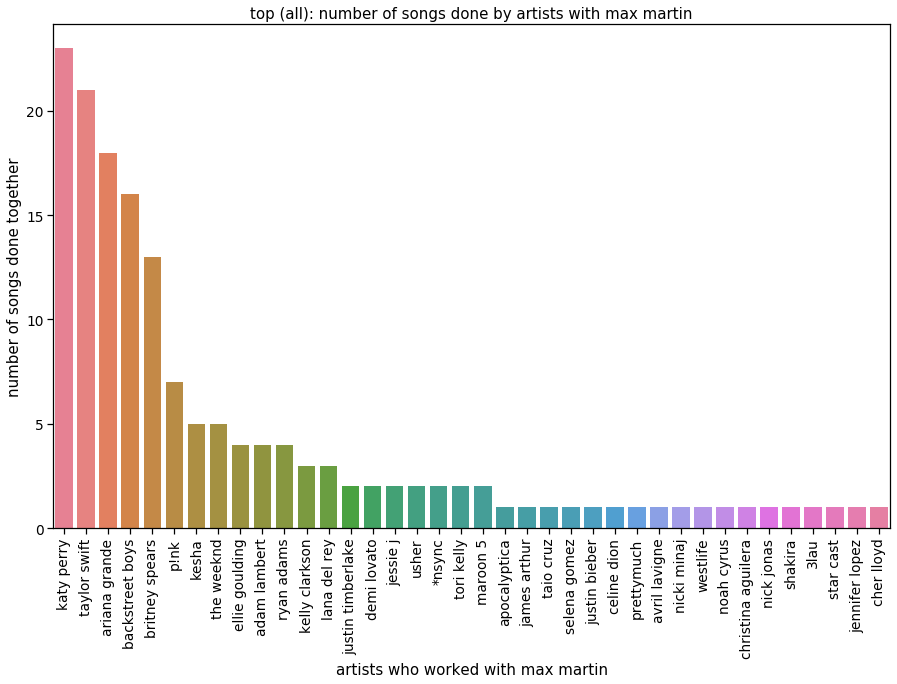

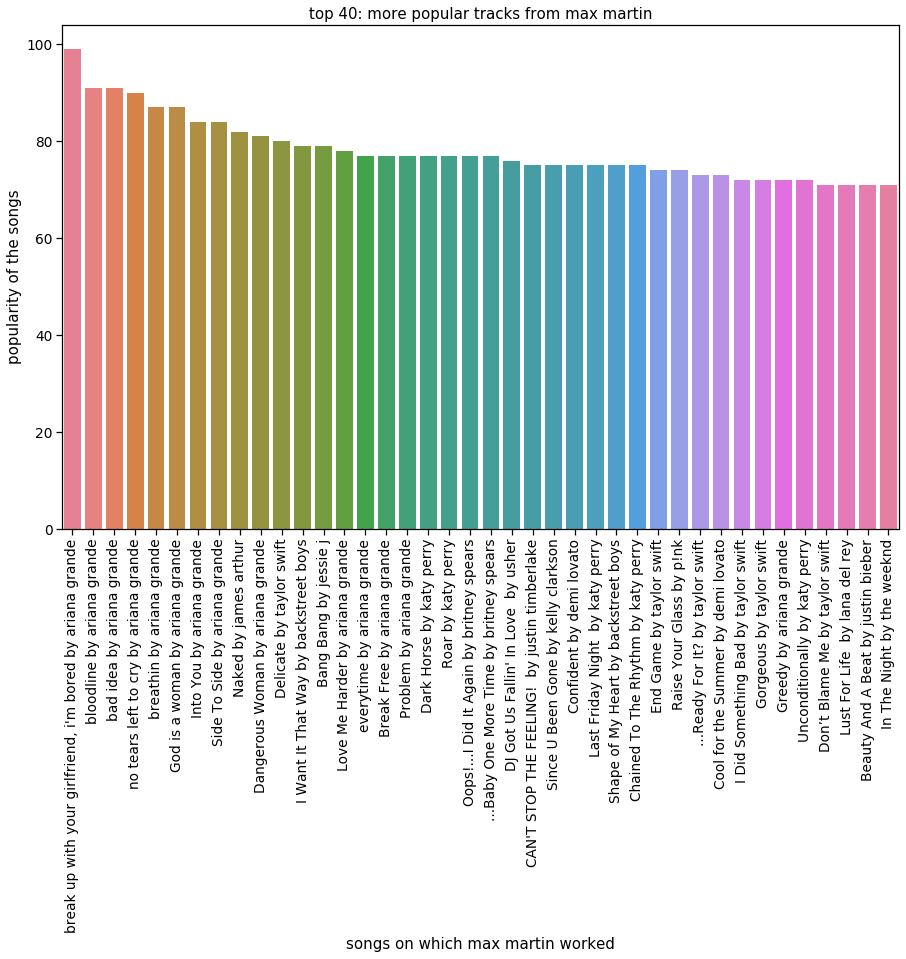

In [9]:
study_actor(final_dataframe, 'max martin', 'songwriters')

As you can see in the barplots above, Our dataframe allows us to infere that Max Martin worked with lots of pretty big name of the industry as Katy Perry, Arianna Grande, the Backstreet Boys, etc... We could also suppose that his songs are pretty well received by the audience since lots of them are above the 70 popularity bar. Finally, looking on the song he worked on, we could say that he wrote a full album for Arianna Grande (in fact the last one) and he's at the origin of pretty big hits from the 2000s and 2010s. Finally we can see that he works mostly on the pop genre.

What could be interesting then is also looked into known interprets to see if they worked with other people than themselves as songwriters. As example, we decided to select the very popular pop singer Ed Sheeran

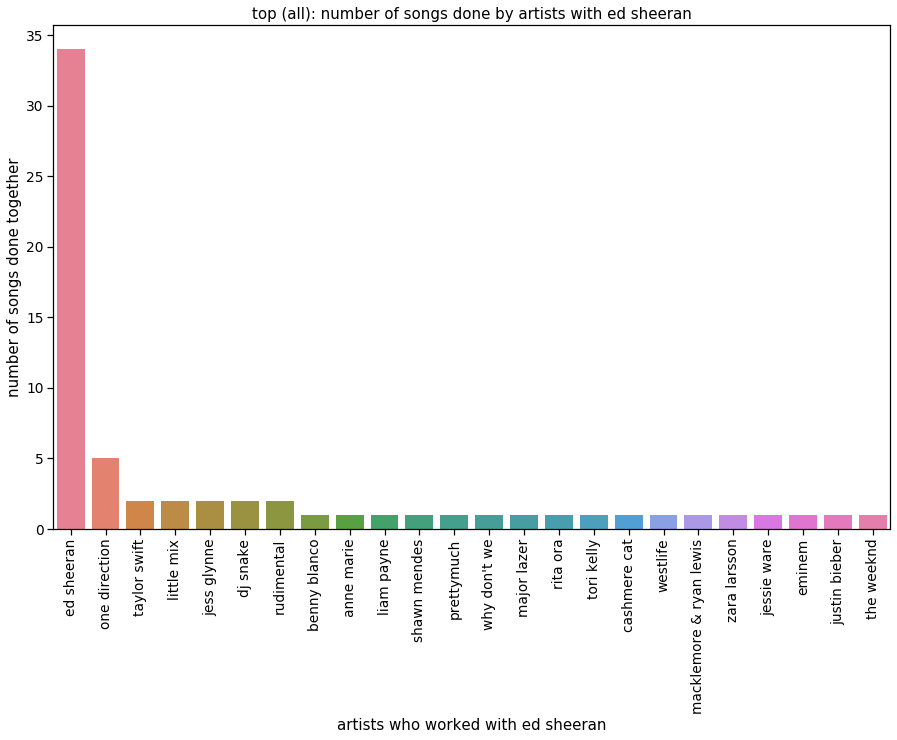

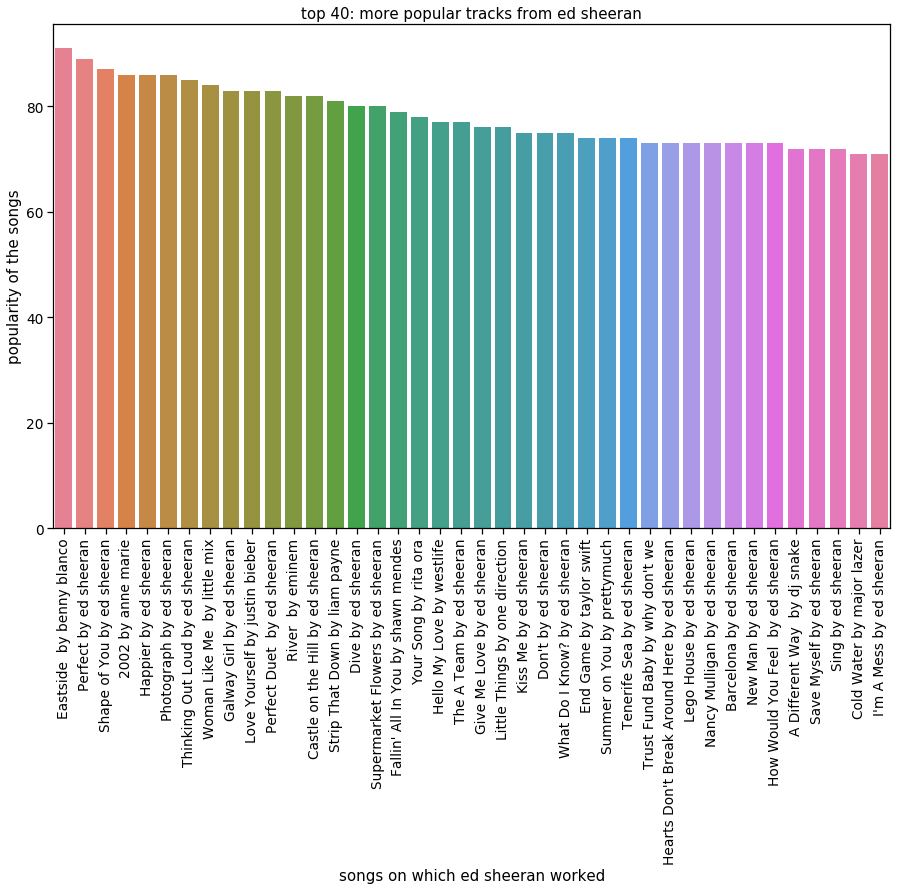

In [10]:
study_actor(final_dataframe, 'ed sheeran', 'songwriters')

This study give us that he wrote for lots of other popular pop artists and that the majority of his songs are doing really well. Indeed more than 40 of his songs are above the 75 popularity line which is really impressive.

### A quick study of the labels

One big part of the musical word we didn't talked about already is the different labels. a record label is a brand or trademark associated with the marketing of music recordings.What could be interessting would be to look into the biggest labels in our dataset and see with which artists they are working. One thing we should take into consideration is that the music evolves a lot. Before the 2000s this study could have shown that there was not that much of big labels and that lots of the biggest names were signed to the biggest one. But since the 2000s, lots of big artists and producers start to create their own record label to control everything about their songs. This change in the industry could lead to a very messy data, where the number of label has exploded. To solve this problem, it would have been great to approach the data years by year to study the evolution over time of both the number of labels and with which labels each interprets worked with.

Below, we are first creating the list of all the labels contained in our dataset (we removed the *independent* one we defined at the start of our study to not messed up the barplot scale cause the majority of the songs in the data are considered as being linked to no record labels). Then we use this list to plot the 50 biggest labels in our dataframe.

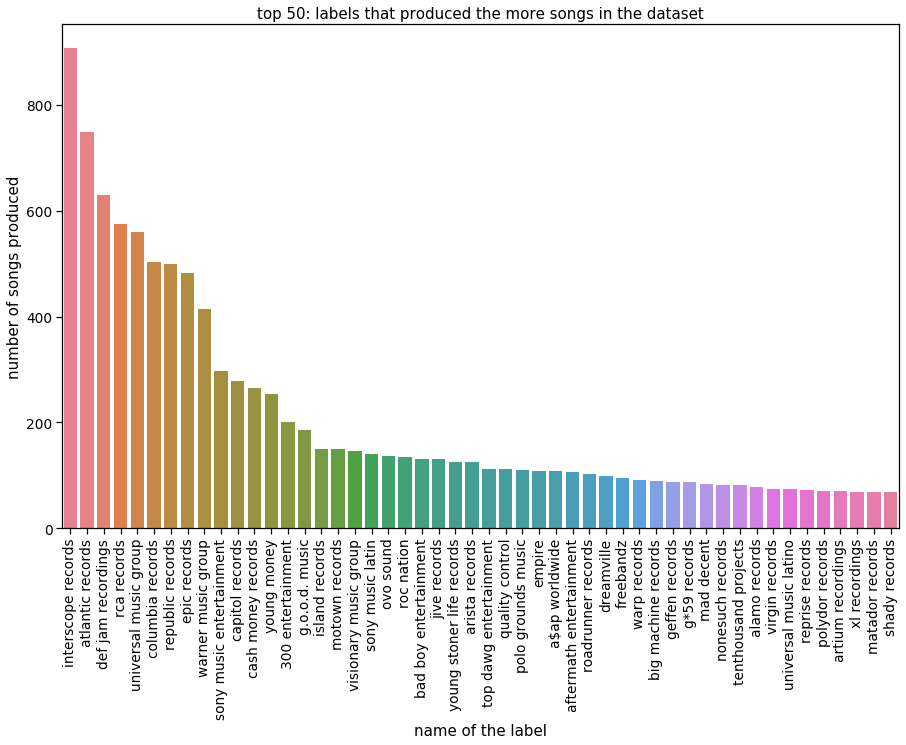

In [11]:
# creation of the list of all the labels in our dataframe
labels_list = []
for list_ in final_dataframe['labels'].values:
    for elem in list_:
        if elem != 'independent':
            labels_list.append(elem)

# now lets count the number of occurences of each labels in our dataset
labels_dictionnary = dict(collections.Counter(labels_list))

# lets plot our data (50 most common)
plot_n_most_common_persons(labels_dictionnary, 50, x_lab='name of the label', y_lab='number of songs produced',\
                           title='labels that produced the more songs in the dataset')

From the barplot above, we can see that the label present in our dataframe did not produced that much songs (Our dataset contains around 70000 unique songs and the biggest label worked only on around 900 of them which is a pretty small number). This analysis could show the phenomenom we presented earlier: the musical word has changed in the last 10 years and the labels will not be as useful as we wanted to find relationships between the actors in our dataset (for example we could have linked all artists in the same label one with another). But, these results could also come from our parsing and the way the informations are stored on Genius (remember that Genius is a collaborative platform, thus informations about songs could miss or be omitted since the main purpose of the website is to retrieve lyrics of any songs). Finally, this barplot doesn't show that lots of the labels are in fact sub labels of other bigger ones. For example the record label Universal music group is also at the head of universal music latino.

Just for fun, we looked below into one specific label which is Atlantic Records.

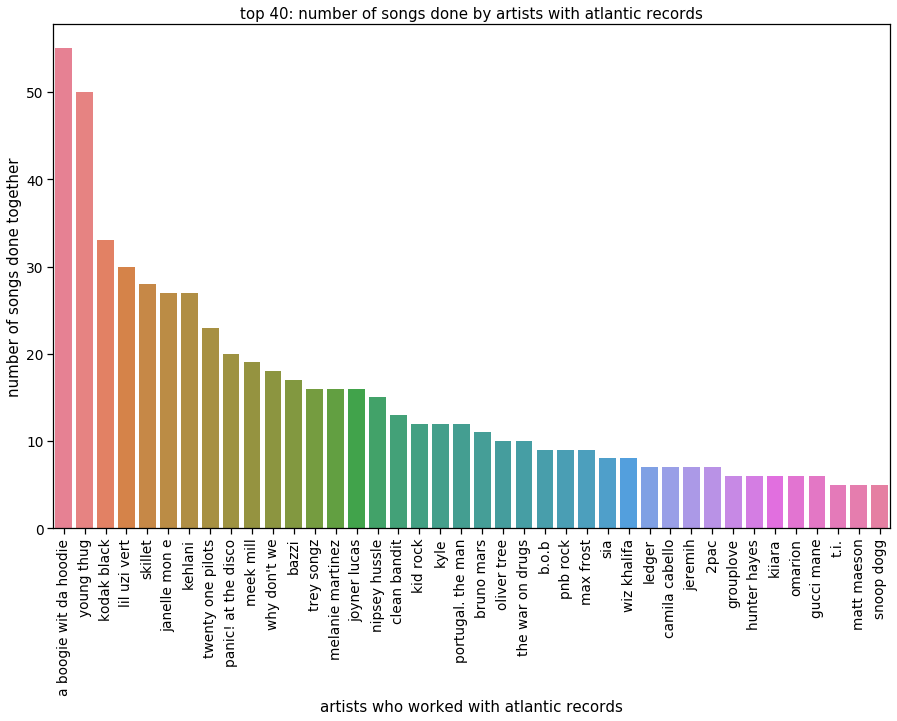

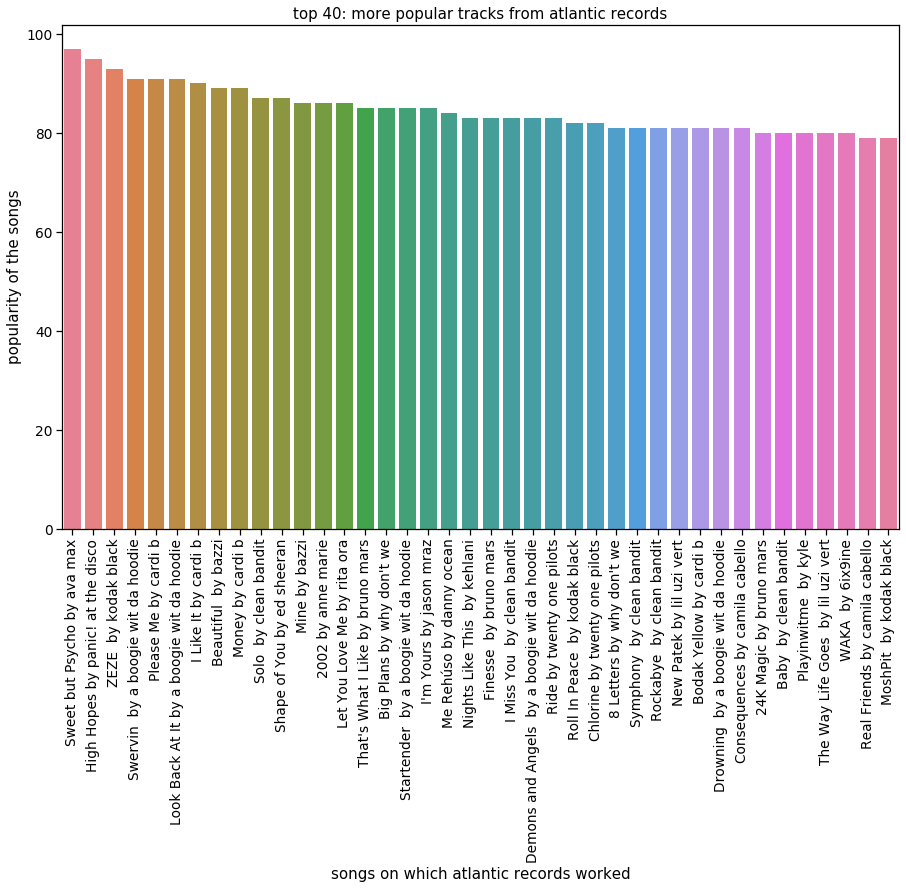

In [12]:
study_actor(final_dataframe, 'atlantic records', 'labels')

### A quick study of the producers

What we can do now is repeat all the operations we have done before to do a study of the different producers in our dataset. Even before going into the analysis, we can predict that lots of the interprets will still be also labelled as producer of their own songs. Thus lots of the name in this column should be similar to the ones we retrieved in the songwriters study.

As before the first we do is to create a list of the producers we can find in dataframe so that we can obtain the number of occurences of each one of them.

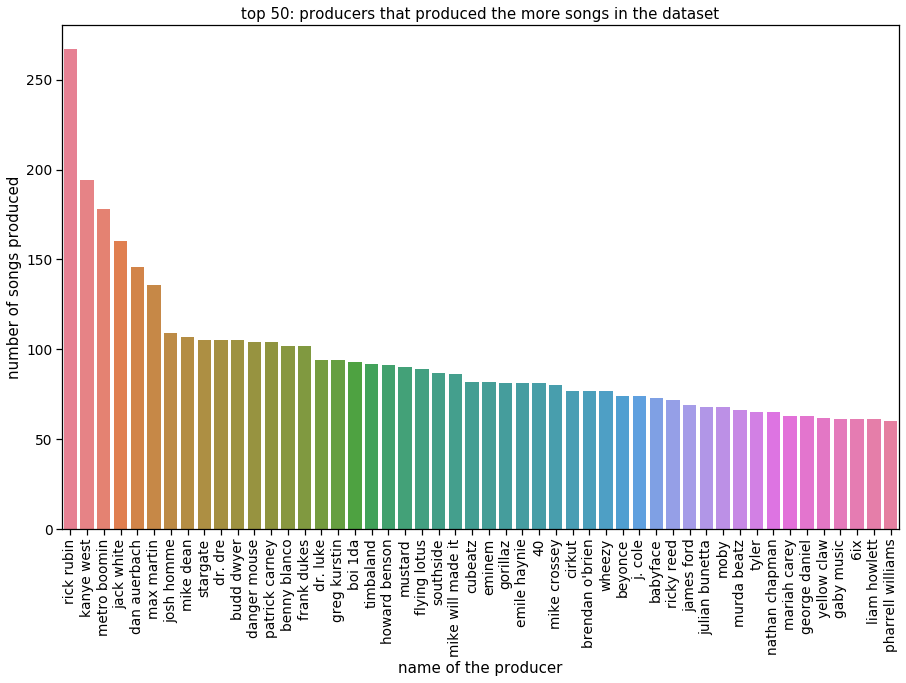

In [13]:
# creation of the list of all the producers in our dataframe
producers_list = []
for list_ in final_dataframe['producers'].values:
    for elem in list_:
        producers_list.append(elem)

# now lets count the number of occurences of each producers in our dataset
producers_dictionnary = dict(collections.Counter(producers_list))

# lets plot our data (50 most common)
plot_n_most_common_persons(producers_dictionnary, 50, x_lab='name of the producer', y_lab='number of songs produced', title='producers that produced the more songs in the dataset')

The results we obtained are not as we could have expected. Lots of the person present in this list are in fact not known as interprets (and note that the known interpret in this list are also known as big producer, for example Kanye West or Pharell Williams). The producing procedure seems to be pretty independent from the songwritting ones. For example the first name in this list is Rick Rubin who wasn't in any of our previous plots. From his Wikipedia page, Rick Rubin is well known for working a lot in the Rock genre with artist as System of Down or the Red Hot Chili Peppers.

From the study below, we can see that these informations are also present in the data and that the main genre he work on is Rock (even Hard Rock). We can grasp that he also work on any other kind of music (which is in fact pretty true for lots of producers) as shown by his collaboration withe Eminem or kanye West.

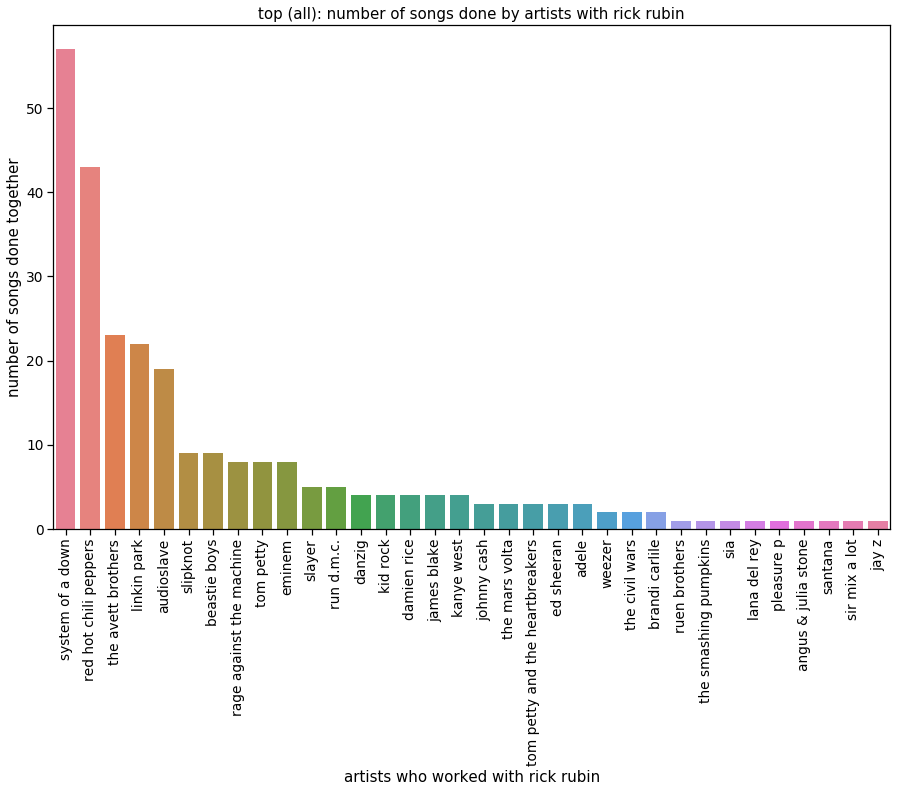

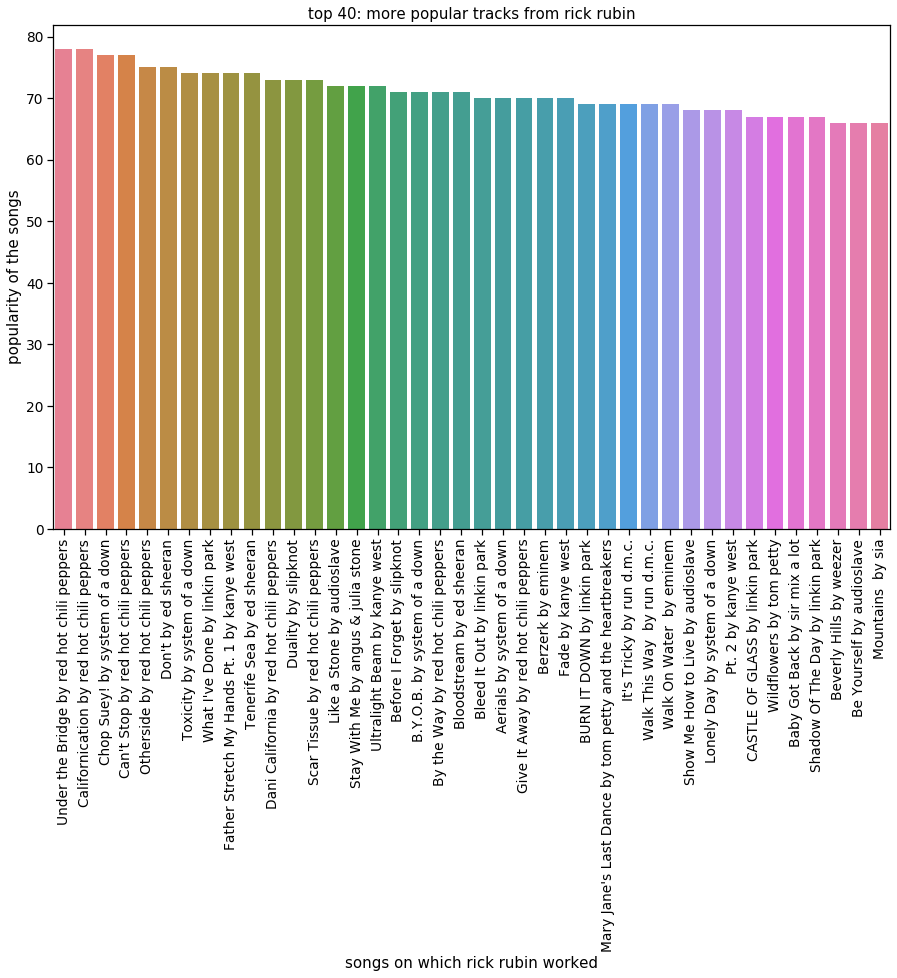

In [14]:
study_actor(final_dataframe, 'rick rubin', 'producers')

This study of a specific producer give us some insight into what our final graph could look like. Since producers seem to work with anyone independently of the songs genre (they have a main one but are still connected to lots of artists from different horizons), they could be translated into big HUBS in our graph. They could also lead to our graph being either fully connected or containing one giant component and lots of people oustide of it that in fact are working on their own. Rick Rubin, for example, seems like to be a pretty big hub in a connected component.

**NOTE FOR GROUP:**  <span style="color:red"><em>If you can, try to do the same things but with genres of musics instead of artists and songs. This would mean redifine functions pretty similar to the one aboves but with some tweaks since we are only interessted in genre. Then plot them using plot_n_most_common_persons() which will still work in this case. </em> text</span>

## Creation of the adjacency matrix

Now that we have finish our quick study of the data, we can create the adjacency matrix that will represent the graph structure of our data. Before creating it, we need to find all the persons (actors) that are present in our full dataset. To do so we defined a function **create_list_of_persons(df)** that retrieve all the unique actors in our dataframe so that we can obtain the shape of our adjacency matrix. Once obtained, we will create the adjacency matrix as presented below.

Note that there are multiple ways to create the adjacency matrix. In our case we create the matrix based on the working relationships such that one collaboration is enough to create a link and consider all the roles in the music industry. We could also have considered that two persons are connected if and only if they worked at least 5 times one with another (more of a friendship oriented graph). Finally we could have considered a graph with only a specific role. For example look at only the relationships between interprets to avoid the big hubs that producers could be.

In [16]:
def create_list_of_persons(df):
    
    '''
    Given a dataframe create the list of persons present in the dataframe (list of all the singers/songwriters/producers)
    INPUT: df: dataframe containing persons
    OUTPUT: list_of_persons: set of all the persons contained in the dataframe
    '''
    
    # let's count the number of distinct person in the dataset
    list_of_persons = []

    for row in df.iterrows():
        artist = row[1]['artist_name']
        writers = row[1]['songwriters']
        producers = row[1]['producers']

        list_of_persons.append(artist)
        for name_ in writers:
            list_of_persons.append(str(name_))

        for name_ in producers:
            list_of_persons.append(str(name_))

    list_of_persons = set(list_of_persons)
    return list_of_persons

In [17]:
list_of_persons = create_list_of_persons(final_dataframe)

Let's create the adjacency matrix. We are gonna fill it in the following way:
1. Initialize the adjacency matrix as a 0s matrix
2. for each row in the dataframe:
    1. look at each person present in the row (artist + writers + producers)
    2. for each person creates edges going from one to another
    3. if the edge doesnt exist set the position in the matrix to 1
    4. else add one to the existing weight

The function **create_all_tuples(set_of_persons)** allows us to obtain all the tuple from a set of unique persons. Then the function **create_adjacency(df, shape)** allows us to create the adjacency matrix but also multiple dictionnary so that we can find which row correspond to which actor, which actors had labels or not and finally how many songs were produced by each actor.

In [18]:
def create_all_tuples(set_of_persons):
    
    '''
    given a set of persons, create all possible tuples of persons in the set
    INPUT: set_of_persons: a set of persons who worked on the same song
    OUTPUT: list_: list of all possible tuples
    '''
    
    set_of_persons = list(set_of_persons)
    list_ = [(set_of_persons[i],set_of_persons[j]) for i in range(len(set_of_persons)) for j in range(i+1, len(set_of_persons))]
    return list_

def create_adjacency(df, shape):
    
    '''
    Given a dataframe containing artists, songwriters and producers, create the adjacency matrix such that two persons that
    worked together on the same songs are linked by an edge.
    INPUT: df: music dataframe containing our singers/songwriters/producers
           shape: shape of the adjacency matrix we want to create
    OUTPUT: adjacency: numpy array, the adjacency matrix representing the working relationships present in the dataset
            nodes_dictionnary: dictionnary that associates each index in the adjacency matrix to the corresponding person in the 
                               dataset
            labels_dictionnary: dictionnary that associates each index in the adjacency matrix to a dictionnary containing the 
                                number of time they add a label or not
            number_of_songs: dictionnary that associates each index in the adjacency matrix to the number of songs they created
    '''
    
    adjacency = np.zeros(shape)
    nodes_dictionnary = {}
    labels_dictionnary = {k:{'no_label':0, 'label':0} for k in range(shape[0])}
    number_of_songs = {k:0 for k in range(shape[0])}
    
    idx = 0
    for row in df.iterrows():
        artist = row[1]['artist_name']
        writers = row[1]['songwriters']
        producers = row[1]['producers']
        labels = row[1]['labels']

        persons_in_row = np.concatenate(([artist], writers, producers), axis=None)
        persons_in_row = set(persons_in_row)
        
        if len(persons_in_row) == 1:
            name = list(persons_in_row)[0]
            if name not in nodes_dictionnary.keys():
                nodes_dictionnary[list(persons_in_row)[0]] = idx
                idx +=1
        else:
            
            list_of_tuples = create_all_tuples(persons_in_row)


            for tup in list_of_tuples:
                node_1 = tup[0]
                node_2 = tup[1]

                if node_1 not in nodes_dictionnary.keys():
                    nodes_dictionnary[node_1] = idx
                    idx +=1

                if node_2 not in nodes_dictionnary.keys():
                    nodes_dictionnary[node_2] = idx
                    idx +=1
                    
                i = nodes_dictionnary[node_1]
                j = nodes_dictionnary[node_2]

                adjacency[i][j] += 1
                adjacency[j][i] += 1
        
        for name in persons_in_row:
            index = nodes_dictionnary[name]
            number_of_songs[index] +=1
            if 'independent' in labels and len(labels) == 1:
                labels_dictionnary[index]['no_label'] +=1
            else:
                labels_dictionnary[index]['label'] +=1
         
    return adjacency, nodes_dictionnary, labels_dictionnary, number_of_songs

def check_adjacency(list_of_persons, nodes_dictionnary):
    
    '''
    Function that allow us to check if our adjacency was well constructed.
    INPUT: list_of_persons: list of all persons that we need to find in the nodes dictionnary
           nodes_dictionnary: dictionnary containing all the ids corresponding to the persons in the list_of_persons
    OUTPUT: bool_: boolean; True if some people were missed while creating the adjacency else False
            list_of_missed: list of people that we missed when creating the adjacency
    '''
    
    list_of_missed = []
    bool_ = False
    for elem in list_of_persons:
        if elem not in nodes_dictionnary.keys():
            list_of_missed.append(elem)
            
    if len(list_of_missed) != 0:
        bool_ = True
    
    print(bool_)
    return bool_, list_of_missed

In the cell below, we create the adjacency matrix for our full dataframe. Note the function **check_adjacency(list_of_persons, nodes_dictionnary)** that allows us to verify if the adjacency matrix was well create or not

In [19]:
# Lets create the adjacency matrix of our dataframe
len_ = len(list_of_persons)
shape = (len_, len_)

adjacency, nodes_dictionnary, labels_dictionnary, number_of_songs = create_adjacency(final_dataframe, shape)

# check either our adjacency was well created or not
check_adjacency(list_of_persons, nodes_dictionnary)

G_person_full = nx.from_numpy_matrix(adjacency)

False


## Creation of the graph

Now that the adjacency matrix has been well created, we are going to create the graph. To do so we are going to use the networkx library. This library is really powerful and has the advantages to be well compatible with the plotting library Bokeh. Thus using Bokeh, we will be able to create interactive graph where you will be able to surf through the graph and obtain information about each of the nodes. In our case, a node will contain the name of the person, the number of songs he worked on, his degree value called size and if either he has a label in general or not. An edge, on the other hand, will contain the list of songs on which two persons worked one with another.   

Below we decided to do the work only on a fraction of the data because of the lags induced by graph being to big in Bokeh. We set a random seed at the start so that the test dataframe always have the contents.

In [48]:
#for testing purpose
test = final_dataframe.sample(frac=0.1, random_state= 15)
list_of_persons = create_list_of_persons(test)

# Lets create the adjacency matrix of our dataframe
len_ = len(list_of_persons)
shape = (len_, len_)

adjacency, nodes_dictionnary, labels_dictionnary, number_of_songs = create_adjacency(test, shape)
# check either our adjacency was well created or not
check_adjacency(list_of_persons, nodes_dictionnary)

# creation of the graph
G_person = nx.from_numpy_matrix(adjacency)

False


Then we add all the meta information to each nodes of the graph. We also compute the number of connected components we can find in the graph. Note that we can easily add the information about the songs on each edge but we dont do so cause the graph would overcrowd by informations.

In [49]:
# First we need to change the order of the dictionnary nodes_dictionnary
nodes_to_names = { v:k for k,v in nodes_dictionnary.items()}
labels_dictionnary = {k: max(v.items(), key=operator.itemgetter(1))[0] for k,v in labels_dictionnary.items()}


# Let's set the attibutes
nx.set_node_attributes(G_person, nodes_to_names, 'name')
nx.set_node_attributes(G_person, labels_dictionnary, 'label')
nx.set_node_attributes(G_person, number_of_songs, 'number_of_songs')

# print the number of connected components in the graph
print(nx.number_connected_components(G_person))

559


We can see that there is lots of connected components in our graph. This number can be explained because our graph is not fully connected. In fact, in the music industry, lots of people seems to work only with a small group of associates or even alone. Int he graph you can find below, lots of this connected components are in fact just single nodes not connected at all to the rest of our graph. 

Now that we found the connected components present in our graph, we decided to compute the hubs score of each nodes in the graph. The function **find_hubs(G_person, nodes_to_names, number_hubs)** allows to retrieve the n persons with the highest hubs score in our sample of the data. In the following cells, we decided to find the top 10 persons in the test dataframe. 

In [50]:
def find_hubs(G_person, nodes_to_names, number_hubs):
    
    '''
    Given a graph of person and the number of hubs desired, print the top number_hubs hub in the graph
    INPUT: G_person: nx graph obtained from an adjacency matrix
           number_hubs: number of hubs we desire to print
    '''
    
    hubs, auth = nx.hits(G_person, max_iter=5000, tol=0.0001)
    sorted_hubs = {k: v for k, v in sorted(hubs.items(), key=lambda item: -item[1])}
    print("the main hubs in our graph are:" + '\n')
    counter = 0
    for index in sorted_hubs.keys():
        if counter <number_hubs:
            print( str(counter + 1) + ': ' + nodes_to_names[index])
            counter +=1

In [51]:
# Let's find the 10 most important hubs in our testing dataset
find_hubs(G_person, nodes_to_names, 10)

the main hubs in our graph are:

1: dom mclennon
2: brockhampton
3: kevin abstract
4: merlyn wood
5: ameer vann
6: romil hemnani
7: matt champion
8: jabari manwa
9: joba
10: q3


The results above are really interesting cause they both show that the adjacency was well created but also that we have a flow in the manner the data is presented.
First, after some research we found out that all the persons prensent in the top 5 are in fact members of the band brockhampton or producers of the band. This insights means that there are lots of interconnection between the bands member cause they all worked one with another multiple times and works with each other the majority of the time. This analysis also leads to one problem. Bands member are present in the graph at the same time that the band name leading to lots of connection that in fact means nothing except that they people in the same band works one with another. A good way to change this would be to remove the nodes corresponding to the bands name (which is really hard) cause the bands are already represented by the big intereconnection between the members. 

On the good side, we can see that all these persons with the highest hubs score correspond to the same music genre: Hip-Hop. This could be explain in two ways: either the Hip-Hop world is really well connected with itself or the actors of the Hip-Hop words are at the center ofthe all graph for our sample of the sample data.

In the following cell, we are going to take care of the plotting using Bokeh and the functioon **bokeh_plot(G_person, size='number_of_songs')** with a color map corresponding to the connected component in which the actor is. Note that all actors in a connected component of less than 20 people are colored as green.

In [81]:
def bokeh_plot(G_person, size_='number_of_songs', iterations=50):
    
    '''
    Given a graph of person and the desired size of the nodes (string corresponding to the name of one of the arguments 
    of the graph), return a interactive plot that can be shown
    INPUT: G_person: nx graph obtained from an adjacency matrix
           size: attribute desired to be the size of a node
    OUTPUT: plot: a bokeh plot that is interactive
    '''
    
    plot = Plot(plot_width=1200, plot_height=1200,
                x_range=Range1d(-1.1, 1.1), y_range=Range1d(-1.1, 1.1))
    plot.title.text = "Working relationships in the musical word"

    node_hover_tool = HoverTool(tooltips=[("index", "@index"), ("name", "@name"), ("label", "@label"), ("number_of_songs", \
                                                                                                       "@number_of_songs") \
                                                                                                      , ("size", "@size")])
    plot.add_tools(node_hover_tool, BoxZoomTool(), ResetTool(), WheelZoomTool(), PanTool())

    graph_renderer = from_networkx(G_person, nx.spring_layout, scale=1, center=(0, 0), iterations=iterations)

    graph_renderer.node_renderer.glyph = Circle(size=size_, fill_color='color')
    graph_renderer.edge_renderer.glyph = MultiLine(line_color='lightgray', line_alpha=0.8, line_width=1)
    plot.renderers.append(graph_renderer)
    return plot

In [56]:
# Create a color map for plotting depending on the connected component the person is in
nodes_color = {}
color_index=20

# Note that we consider all connected components of size less than 21 inexistent (all the nodes have the same color).
for set_ in nx.connected_components(G_person):
    if len(set_) > 20:
        for k in set_:
            nodes_color[int(k)] = Inferno256[-color_index]
        color_index +=40
    else:
        for k in set_:
            nodes_color[int(k)] = 'green' 

# Prepare other attribute of the graph as the color or the size of the nodes
nx.set_node_attributes(G_person, nodes_color, 'color')
degree_list = nx.degree(G_person)
size = {v[0]:v[1]*0.5 for v in degree_list}           
nx.set_node_attributes(G_person, size, 'size')
plot = bokeh_plot(G_person, size_= 'number_of_songs')

show(plot)

## Graph analysis using different clustering algorithms

Now that we have an adjacency matrix and a graph, we can start trying to cluster the different nodes present in the graph.
To do so we are going to try multiple clustering methods:
1. **Spectral clustering**: uses information from the eigenvalues (spectrum) of special matrices to obtain the community of each node
2. **DBSCAN**: "given a set of points in some space, it groups together points that are closely packed together (points with many nearby neighbors)" (Wikipedia) Notes that outliers are the nodes found in low density spaces and are denoted in python with the label -1.
3. **Louvain mehthod**: extract communities from large networks by optimization of the modularity value which "measures the strength of division of a network into modules" (Wikipedia).

Since our graph since to represent a real world network and as the shape which seems well adapted for it, we decided to first apply spectral clustering to find communities. We assumed spectral clustering was a nice idea cause it allows to find non gaussian communities which an algorithm like K-means cant do.

In [59]:
# Creation of the clustering using spectral clustering
clustering = SpectralClustering(n_clusters=2, assign_labels="discretize", random_state=0, affinity='precomputed')\
                                                                                                .fit(adjacency)

C:\Users\Alexis\Anaconda3\lib\site-packages\sklearn\manifold\spectral_embedding_.py:235: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


Now we are going to plot the clusters using different colors and the networkx plotting functions just to see what they look like.

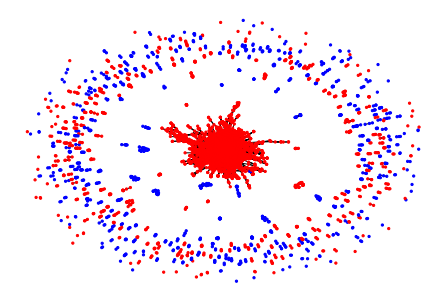

In [60]:
# creation of the color map and drawing of the graph
color_map = ['red' if label == 0 else'blue' for label in clustering.labels_]
nx.draw(G_person, node_size=5, node_color=color_map, with_labels=False)

Using spectral clustering, we can see the presence of, as we could have assumed previously, a big clusters of person all well connected. All the biggest name in the industry (big producers, singers, songwriters) are there. On the second ring of the graph, we can see that the clustering doesn't work at all. In fact nearly all the poitns have at most 2 connections. In general these people are person who created approximately one song.

What we can try now is using others clustering method like DBSCAN which use the neighboring principle to create the communities. First lets find the mean distance in our graph between two nodes cause we will use it as the threshold for telling if either two nodes are neighbours or not.

In [61]:
mean_distance = []

for i in range(adjacency.shape[0]):
    for j in range(i+1,adjacency.shape[0]):
        mean_distance.append(np.linalg.norm(adjacency[i] - adjacency[j]))

eps = np.mean(mean_distance)
print(eps)

4.315380062687381


Because we know that the mean distance between two nodes is influenced by the exterior circle in the graph, we decided to divided it by three to obtain our threshold.

In [67]:
clustering = DBSCAN(eps=eps/3, min_samples=5).fit(adjacency)

color_map = {}
number_of_clusters = len(set(clustering.labels_))
list_of_colors = random.sample(Inferno256, number_of_clusters)

for i, label in enumerate(clustering.labels_):
    color_map[i] = list_of_colors[label]

c = Counter(clustering.labels_)

# Prepare other attribute of the graph as the color or the size of the nodes
nx.set_node_attributes(G_person, color_map, 'color')
degree_list = nx.degree(G_person)
size = {v[0]:v[1]*0.5 for v in degree_list}           
nx.set_node_attributes(G_person, size, 'size')

#drawing
plot = bokeh_plot(G_person, size_= 'number_of_songs')
show(plot)

#nx.draw(G_person, node_size=5, node_color=color_map.values(), with_labels=False)

With the plotting above, it seems like DBSCAN doesn't work really well. All the yellow clusters contained in fact wat are supposed to be outliers (labelled as -1). All the others communities are not that much populated and in fact consists of small groups of nodes in the exterior circle. 

Because of the failures of this algorithm and the fact that spectral clustering only shows that the musical words is composed of a part of well connected people (all the popular artists) and another were the distribution is kind of random (all the persons working in small groups or alone). We decided to try a third and last clustering method which is the Louvain methods. To do so we used the python version contained in the library **python-louvain** (imported as **community**) implemented by Thomas Aynaud. As said previously, this algorithm has for goal to find communities in a graph using the modularity values.

In the cell below, we apply the algorithm and plots the obtained partitions using coloring.

In [74]:
#first compute the best partition
partition = community.best_partition(G_person)

size = int(len(set(partition.values())))
colors = random.sample(set(np.array([Viridis256, Inferno256, Cividis256]).flatten()), size)

# creation of the color map
color_map = {}
for com in set(partition.values()) :
    color = colors[com]
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    for node in list_nodes:
        color_map[node] = color

# Prepare other attribute of the graph as the color or the size of the nodes
nx.set_node_attributes(G_person, color_map, 'color')
degree_list = nx.degree(G_person)
size = {v[0]:v[1]*0.5 for v in degree_list}           
nx.set_node_attributes(G_person, size, 'size')

#drawing
plot = bokeh_plot(G_person, size_= 'number_of_songs')
show(plot)

As you can see above, the results obtained using Louvain algorithm are far more promising (note we are still working with only % of the data so what we discuss here is not necesseraly true on the full dataset). We can see that the groups are far more logical than before. For example we can see that Eminem is placed in a community with dr Dre while the others more modern rappers are in a cluster around Drake, Lil Uzi, etc... Rick Rubin seems to be the main hub of a more pop/rock cluster as we can see the presence of System of a Down and Red Hot Chili Pepers. 

From this analysis, we can see that the Louvain method seems to find communities corresponding to genre of music and go more in depth than a simple rap/pop limitation. It seems to find which type of rap a persons do based on the collaboration between people. On 10% of the full dataset, it seems like graph clustering is able to reconstruct music genres based cluster and seems to tell that people of a specific genre, generally works one with another and do go that much outside of their comfort zone.

## Analysis: the popular songs approach

In this section, we are going to redo the work you've seen before but only on a specific part of the dataframe. In fact, what we obtained above using DBSCAN is that the data is really noisy. Lots of actors are not connected and the clustering algorithms cant work that well on this kind of graph. Also we found out that Louvain could help us clustering our dataset really well. 

We then decided to keep only songs that are considered popular on spotify. These songs are the one with a popularity of at least 70. With this approach we hope to have a cleaner data with far less persons at the exterior of the big circle in the center of the graph and also far less connections to obtain clearer clusters.

In [75]:
# Let's keep only the more popular songs in the dataframe
popular_songs = final_dataframe[final_dataframe['popularity'] >= 70]

# print the head of the new dataframe and its length
print(len(popular_songs))
popular_songs.head(5)

2818


track_name     artist_name  \
8                   Hero    mariah carey   
10              Tip Toe     jason derulo   
19                Dinero  jennifer lopez   
20  Hate That I Love You         rihanna   
26                  OMG            usher   

                                          songwriters  \
8                   [mariah carey, walter afanasieff]   
10  [french montana, jason derulo, johnny mitchell...   
19  [alexander prado, cardi b, danileigh, dj khale...   
20  [mikkel storleer eriksen, ne yo, rihanna, tor ...   
26                                 [usher, will.i.am]   

                            producers                labels genre popularity  
8   [mariah carey, walter afanasieff]    [columbia records]   R&B         71  
10                       [bantu, pip]         [independent]   R&B         76  
19                [dj khaled, tbhits]         [independent]   R&B         70  
20                         [stargate]  [def jam recordings]   R&B         72  
26                        [will.i.am]         [independent]   R&B         70

Now that the dataframe of popular songs is ready, we can use all the functions we have created before hand to set up the adjacency matrix.

In [76]:
# list of all persons who created popular songs
list_of_persons_popular = create_list_of_persons(popular_songs)

# Lets create the adjacency matrix of our dataframe
len_ = len(list_of_persons_popular)
shape = (len_, len_)

adjacency_popular, nodes_dictionnary_popular, labels_dictionnary_popular, \
                                number_of_songs_popular = create_adjacency(popular_songs, shape)
# check either our adjacency was well created or not
check_adjacency(list_of_persons_popular, nodes_dictionnary_popular)

# creation of the graph
G_person_popular = nx.from_numpy_matrix(adjacency_popular)

False


In the cell below, we add the informations related to each nodes and prepare the plotting

In [77]:
# First we need to change the order of the dictionnary nodes_dictionnary
nodes_to_names_pop = { v:k for k,v in nodes_dictionnary_popular.items()}
labels_dictionnary_popular = {k: max(v.items(), key=operator.itemgetter(1))[0] for k,v in labels_dictionnary_popular.items()}
#genres_dictionnary_popular = {v: find_main_genre_for_given_person(popular_songs, k) for \
                                                                                      #k,v in nodes_dictionnary_popular.items()}


# Let's set the attibutes
nx.set_node_attributes(G_person_popular, nodes_to_names_pop, 'name')
nx.set_node_attributes(G_person_popular, labels_dictionnary_popular, 'label')
nx.set_node_attributes(G_person_popular, number_of_songs_popular, 'number_of_songs')
#nx.set_node_attributes(G_person_popular, genres_dictionnary_popular, 'genre')

# print the number of connected components in the graph
print(nx.number_connected_components(G_person_popular))

# Let's find the 10 most important hubs
find_hubs(G_person_popular, nodes_to_names_pop, 10)

# Create a color map for plotting depending on the connected component the person is in
nodes_color_popular = {}
color_index=20

# Note that we consider all connected components of size less than 21 inexistent (all the nodes have the same color).
for set_ in nx.connected_components(G_person_popular):
    if len(set_) > 20:
        for k in set_:
            nodes_color_popular[int(k)] = Viridis256[-color_index]
        color_index +=40
    else:
        for k in set_:
            nodes_color_popular[int(k)] = 'green' 


# Prepare other attribute of the graph as the color or the size of the nodes
nx.set_node_attributes(G_person_popular, nodes_color_popular, 'color')
degree_list = nx.degree(G_person_popular)
size = {v[0]:v[1]*0.2 for v in degree_list}           
nx.set_node_attributes(G_person_popular, size, 'size')
plot = bokeh_plot(G_person_popular, size_= 'size')

186
the main hubs in our graph are:

1: mike dean
2: kanye west
3: travis scott
4: cyhi the prynce
5: drake
6: metro boomin
7: quavo
8: noah goldstein
9: offset
10: cubeatz


In [78]:
show(plot)

Above we can see that we have a far smaller graph with far less connected components than before. We still have the big connected components in the middle representing the majority of the industry. Far less people outside of this group seems to be popular. We can find one interesting cluster containing the Foo Fighters, Nirvana (which makes sense knowing the groups composition) and My Chemical Romance. From this graph we could say that the songs that works in todays world are produced by a small set of interconnected people that work a lot one with another. There are some exceptions but they only represent a small part of the popular songs.

We can try to apply once again some spectral clustering to the graph to see if we can obtained clusters of people who work one with another. We hope the clusters to be cleaner than the one obtain previously on a more diverse data.

In [82]:
#first compute the best partition
partition = community.best_partition(G_person_popular)

size = int(len(set(partition.values())))
colors = random.sample(set(np.array([Viridis256]).flatten()), size)

# creation of the color map
color_map = {}
for com in set(partition.values()) :
    color = colors[com]
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    for node in list_nodes:
        color_map[node] = color

# Prepare other attribute of the graph as the color or the size of the nodes
nx.set_node_attributes(G_person_popular, color_map, 'color')
degree_list = nx.degree(G_person_popular)
size = {v[0]:v[1]*0.2 for v in degree_list}           
nx.set_node_attributes(G_person_popular, size, 'size')

#drawing
plot = bokeh_plot(G_person_popular, size_='size', iterations=100)
show(plot)

Here the community created by the Louvain algorithm are really interessting. All the popular pop/RNB artists can be found in two  communities (one with Ed Sheeran, Justin Bieber, etc... for example and another with Ariana Grande, Nicki Minaj, etc...). A big community of modern rap can be found containing artists like Drake, Post Malone, Travis Scott, etc... Old school Rap is on another side with lots of rappers that worked with Dr Dre (Eminem, Snoop Dog, 50 Cents). From this we can see a hiatus in the rap genre between the artists from the 1990s and 2000s and the ones from the years 2010s. They dont work with each other much. Also the modern rap music is far more associated to the pop genre than before. What we can see also here is the absence of Rock music in the most popular songs and the existence of a spanich community (reggaeton genre).

One interessting thing is that people that we know are friend in real life are in the same community. For example the member of Fall out Boy are in the same community than the band Panic! at the Disco which they discovered. We can also note that popular artist that works on a genre different than the more common pop music are in other community than the big pop one. For example Bruno Mars is not in the same community than all other big pop artists.

From this part, we can extract the fact that our graph captures well the relationships between people and even achieve to do sub genres division between artists. It seems to be able to find some relationships between people that not necessarily work with one and another directly but are known to be acquaintance. 

## Analysis: the genre based approach (Rap/Hip-Hop case)

Now that we have made an analysis of the popular songs contained in the data, we decided to look more into depth into genre specific communities. As we saw before, Louvain Method seems to show a Hiatus between more of an old school rap and the more modern one. To assess this hypothesis, we decided to look only into Rap/Hip-Hop songs. Also since this genre seems to be the most popular ones at the time of creating the data, we should have a data without much noise.

We first are going to create the corresponding dataframe containing only rap songs. Then we will create the corresponding adjacency matrix in the same way as before and finally we will apply the Louvain method.

In [83]:
# Let's keep only the more popular songs in the dataframe
rap_hip_songs = final_dataframe[final_dataframe['genre'].isin(['Rap', 'Hip-Hop'])]

# print the head of the new dataframe and its length
print(len(rap_hip_songs))
rap_hip_songs.head(5)

5849


track_name   artist_name  \
17523  MIDDLE CHILD       j. cole   
17524    Going Bad      meek mill   
17525         a lot     21 savage   
17526      Splashin  rich the kid   
17527      Mo Bamba     sheck wes   

                                             songwriters  \
17523                                 [j. cole, t minus]   
17524           [drake, meek mill, westen weiss, wheezy]   
17525  [21 savage, dj dahi, j. cole, j. white did it,...   
17526            [frank dukes, rich the kid, thelabcook]   
17527  [16yrold, david biral, denzel baptiste, emanue...   

                       producers  \
17523         [j. cole, t minus]   
17524     [westen weiss, wheezy]   
17525                  [dj dahi]   
17526  [frank dukes, thelabcook]   
17527  [16yrold, take a daytrip]   

                                                  labels    genre popularity  
17523  [universal music group, interscope records, ro...  Hip-Hop         96  
17524                                      [independent]  Hip-Hop         95  
17525  [sony music entertainment, epic records, slaug...  Hip-Hop         93  
17526                                      [independent]  Hip-Hop         88  
17527  [universal music group, cactus jack records, g...  Hip-Hop         92

In [84]:
# list of all persons who created genre songs
list_of_persons_genre= create_list_of_persons(rap_hip_songs)

# Lets create the adjacency matrix of our dataframe
len_ = len(list_of_persons_genre)
shape = (len_, len_)

adjacency_genre, nodes_dictionnary_genre, labels_dictionnary_genre, \
                                number_of_songs_genre = create_adjacency(rap_hip_songs, shape)
# check either our adjacency was well created or not
check_adjacency(list_of_persons_genre, nodes_dictionnary_genre)

# creation of the graph
G_person_genre = nx.from_numpy_matrix(adjacency_genre)

False


In [85]:
# First we need to change the order of the dictionnary nodes_dictionnary
nodes_to_names_genre = { v:k for k,v in nodes_dictionnary_genre.items()}
labels_dictionnary_genre = {k: max(v.items(), key=operator.itemgetter(1))[0] for k,v in labels_dictionnary_genre.items()}

# Let's set the attibutes
nx.set_node_attributes(G_person_genre, nodes_to_names_genre, 'name')
nx.set_node_attributes(G_person_genre, labels_dictionnary_genre, 'label')
nx.set_node_attributes(G_person_genre, number_of_songs_genre, 'number_of_songs')

# print the number of connected components in the graph
print(nx.number_connected_components(G_person_genre))

# Let's find the 10 most important hubs
find_hubs(G_person_genre, nodes_to_names_genre, 10)

#first compute the best partition
partition = community.best_partition(G_person_genre)

size = int(len(set(partition.values())))
colors = random.sample(set(np.array([Viridis256]).flatten()), size)

# creation of the color map
color_map = {}
for com in set(partition.values()) :
    color = colors[com]
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    for node in list_nodes:
        color_map[node] = color

# Prepare other attribute of the graph as the color or the size of the nodes
nx.set_node_attributes(G_person_genre, color_map, 'color')
degree_list = nx.degree(G_person_genre)
size = {v[0]:v[1]*0.1 for v in degree_list}           
nx.set_node_attributes(G_person_genre, size, 'size')

#drawing
plot = bokeh_plot(G_person_genre, size_= 'size')
show(plot)

162
the main hubs in our graph are:

1: aristos petrou
2: scott arceneaux jr.
3: $uicideboy$
4: budd dwyer
5: pouya
6: germ
7: getter
8: ramirez
9: kaine solo
10: night lovell


The plot above shows that Louvain is really able to detect the sub genres of the artists based on their working relationships one with another. For example, the clustering above is such that we discern multiple communities containing the modern rap music. Each of these communities is centered around one big artists and are such that the persons in it do the same type of musics. Above we have, for example, one community around Drake (more pop sounding rap), one around Kendrick Lamar (more Hip-Hop), one around Kanye West and one with Quavo and Future. Note that we can still see a big co community corresponding to the latino music (around Daddy Yankee). Finally we can observe a separtion between old school rap from the East and the West Coast. One community is centered around Eminem (note that 2pac is of a different color even though he comes from the same group of people than Eminem) and one around the Notorious Big.

In conclusion, our approach seems really nice to find sub-genres in the music industry but also to discern rivality or friendship between people if either they collaborate a lot or never collaborate.

## Analysis: working only with the interprets

Since we like to showcase all the person working on the industry, we studied in the previous analysis both the songwriters and the producers in addition to the singers. This lead to messy clustering cause its seems like the majority of the musical clustering is well connected as we have seen in the two first analysis part (test data and popular songs data). This could come from the fact that producers and songwriters are big hubs that works on lots of different genres.

To try to solve this problem, we will look only into the relationships between the interprets. Two interprets would be (as before) linked if they worked on a song one with another. We first need to recreate a dataframe containing only the interprets name in the columns producers and songwriters. We hope this graph to be less messy and to be far sparser. 

First we are going to find which are the different artists in our dataframe. Then we are going to create the corresponding adjacency using a new functions taking care of the fact that we only wants interprets. Finally we are going to apply the Louvain method to find communities in the graph.

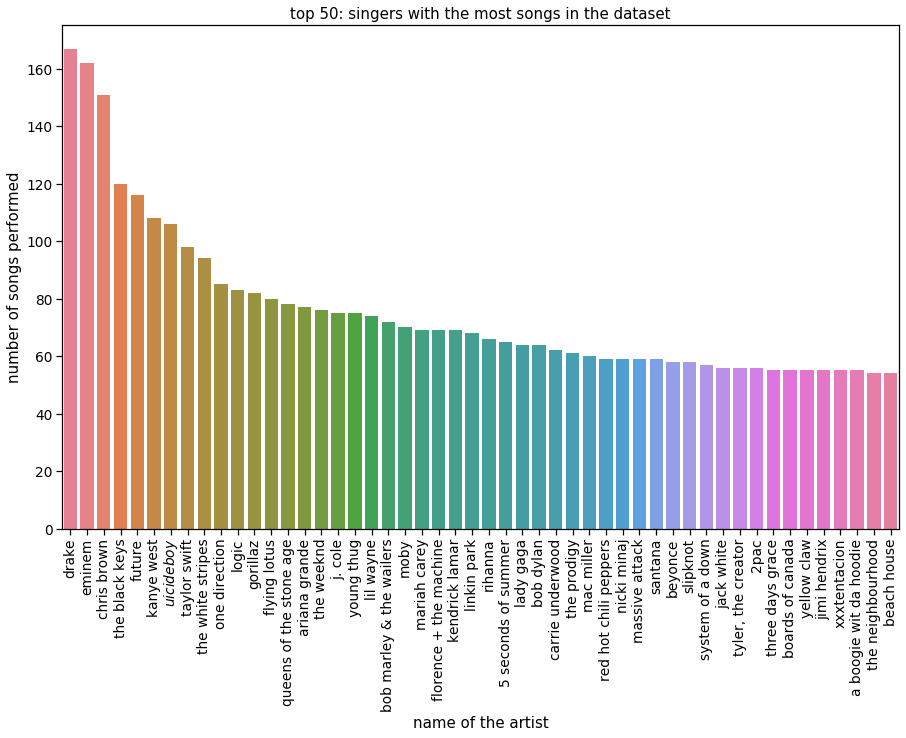

In [86]:
# creation of the list of all the singers (artists) in our dataframe
singers_list = []
for elem in final_dataframe['artist_name'].values:
    singers_list.append(elem)

# now lets count the number of occurences of each producers in our dataset
singers_dictionnary = dict(collections.Counter(singers_list))

# lets plot our data (50 most common)
plot_n_most_common_persons(singers_dictionnary, 50, x_lab='name of the artist', y_lab='number of songs performed',\
                           title='singers with the most songs in the dataset')

In [87]:
def create_adjacency_from_list_of_person(df, list_of_persons,shape):
    
    '''
    Given a dataframe containing artists, songwriters and producers, create the adjacency matrix such that two persons that
    worked together on the same songs are linked by an edge.
    INPUT: df: music dataframe containing our singers/songwriters/producers
           shape: shape of the adjacency matrix we want to create
           list_of_persons: set containing only the persons we are interessted to put in the graph
    OUTPUT: adjacency: numpy array, the adjacency matrix representing the working relationships present in the dataset
            nodes_dictionnary: dictionnary that associates each index in the adjacency matrix to the corresponding person in the 
                               dataset
            labels_dictionnary: dictionnary that associates each index in the adjacency matrix to a dictionnary containing the number of
                                time they add a label or not
            number_of_songs: dictionnary that associates each index in the adjacency matrix to the number of songs they created
    '''
    
    adjacency = np.zeros(shape)
    nodes_dictionnary = {}
    labels_dictionnary = {k:{'no_label':0, 'label':0} for k in range(shape[0])}
    number_of_songs = {k:0 for k in range(shape[0])}
    
    idx = 0
    for row in df.iterrows():
        artist = row[1]['artist_name']
        writers = row[1]['songwriters']
        producers = row[1]['producers']
        labels = row[1]['labels']

        persons_in_row = np.concatenate(([artist], writers, producers), axis=None)
        persons_in_row = set(persons_in_row).intersection(list_of_persons)
        
        if len(persons_in_row) == 1:
            name = list(persons_in_row)[0]
            if name not in nodes_dictionnary.keys():
                nodes_dictionnary[list(persons_in_row)[0]] = idx
                idx +=1
        else:
            
            list_of_tuples = create_all_tuples(persons_in_row)


            for tup in list_of_tuples:
                node_1 = tup[0]
                node_2 = tup[1]

                if node_1 not in nodes_dictionnary.keys():
                    nodes_dictionnary[node_1] = idx
                    idx +=1

                if node_2 not in nodes_dictionnary.keys():
                    nodes_dictionnary[node_2] = idx
                    idx +=1
                    
                i = nodes_dictionnary[node_1]
                j = nodes_dictionnary[node_2]

                adjacency[i][j] += 1
                adjacency[j][i] += 1
        
        for name in persons_in_row:
            index = nodes_dictionnary[name]
            number_of_songs[index] +=1
            if 'independent' in labels and len(labels) == 1:
                labels_dictionnary[index]['no_label'] +=1
            else:
                labels_dictionnary[index]['label'] +=1
         
    return adjacency, nodes_dictionnary, labels_dictionnary, number_of_songs

In [88]:
# Let's create the set of unique singers in the dataframe
list_of_singers = set(singers_list)

# Lets create the adjacency matrix of our dataframe
len_ = len(list_of_singers)
shape = (len_, len_)

adjacency_singers, nodes_dictionnary_singers, labels_dictionnary_singers, \
                                number_of_songs_singers = create_adjacency_from_list_of_person(final_dataframe,\
                                                                                               list_of_singers, shape)
# check either our adjacency was well created or not
check_adjacency(list_of_singers, nodes_dictionnary_singers)

# creation of the graph
G_person_singers = nx.from_numpy_matrix(adjacency_singers)

False


In [89]:
# First we need to change the order of the dictionnary nodes_dictionnary
nodes_to_names_singers = { v:k for k,v in nodes_dictionnary_singers.items()}
labels_dictionnary_singers = {k: max(v.items(), key=operator.itemgetter(1))[0] for k,v in labels_dictionnary_singers.items()}

# Let's set the attibutes
nx.set_node_attributes(G_person_singers, nodes_to_names_singers, 'name')
nx.set_node_attributes(G_person_singers, labels_dictionnary_singers, 'label')
nx.set_node_attributes(G_person_singers, number_of_songs_singers, 'number_of_songs')

# print the number of connected components in the graph
print(nx.number_connected_components(G_person_singers))

# Let's find the 10 most important hubs
find_hubs(G_person_singers, nodes_to_names_singers, 10)

#first compute the best partition
partition = community.best_partition(G_person_singers)

# since we have too many communities, we choose to color only the ones containing 5 or more members
communities = []
for com in set(partition.values()) :
    list_nodes = [nodes for nodes in partition.keys()
                                if partition[nodes] == com]
    if len(list_nodes) >= 5:
        communities.append(com)

size = int(len(communities))
colors = random.sample(set(np.array([Viridis256]).flatten()), size)

# creation of the color map
color_map = {}
index = 0
for com in set(partition.values()):
    if com in communities:
        color = colors[index]
        list_nodes = [nodes for nodes in partition.keys()\
                                    if partition[nodes] == com]
        for node in list_nodes:
            color_map[node] = color
        index +=1
    else:
        color = 'red'
        list_nodes = [nodes for nodes in partition.keys()\
                                if partition[nodes] == com]
        for node in list_nodes:
            color_map[node] = color

# Prepare other attribute of the graph as the color or the size of the nodes
nx.set_node_attributes(G_person_singers, color_map, 'color')
degree_list = nx.degree(G_person_singers)
size = {v[0]:v[1]*0.2 for v in degree_list}           
nx.set_node_attributes(G_person_singers, size, 'size')

#drawing
plot = bokeh_plot(G_person_singers, size_= 'size', iterations=100)
show(plot)

2020
the main hubs in our graph are:

1: quavo
2: offset
3: takeoff
4: migos
5: metro boomin
6: travis scott
7: future
8: drake
9: 21 savage
10: kanye west


As expected, we are nearly left only with the center group of people. Looking at the density of the outside circle, it seems like lots of small artist were helped by lots of people working as producers or songwriters. These connections would thus represent friends group that want to break into the music world.

Even artists wise, we can see that the more popular ones are still pretty much all connected. We can see the sub genre based clusters we talk about previously. Taking the same example as before, we can still see the group of people launch by Dr.Dre in the musical world in the same clusters (Snoop Dog, 2pac, 50 Cents, Eminem, etc...).

From this analysis we can see that in fact, even without the actors working only as producers and songwriters, the popular music is done by a small group of people. These people are well interconnected and even though we can see that artists work more with people doing the same type of music as them.

## Conclusion

In conclusion, we found out with this project that the musical industry is a small well connected world. All the popular songs of our time seems to be the produced by a small group of people where everyone know each other. Also it seems pretty hard to achieve success without knowing people important in the musical industry.

Graph clustering was a good approach to study this industry which pretty much works like a small world. Because our graph was not fully connected. We couldn't computes lots of mesure that would have helped us to understand better the connection between the big name of the industry (like computing the diameter of our graph, with the diameter being defined as the longest path of the shortest paths between any two nodes).

To go deeper into this project, we could have analyzed the evolution of the industry through time by taking into account songs year per year. Also we could have, as said in the introduction, be far more selective on the connection between people in the graph.

**NOTE FOR GROUP:**  <span style="color:red"><em>si possible il faudrait essayer de faire ce dont nous parlons dans l'ouverture, par exemple faire ce graph ou l'on considere un minimum de 5 collaborations pour tracer un edge et faire cette etude du data par annee et selectionne quelques annees pour faire des graphs (normalment vous pouvez concat la final_dataframe avec celle de spotify pour obtenir les annees. (prendre comme cle nom artist nom chanson et popularite.) </em></span>